In [1]:
# C:/Users/광운MOOC센터/Desktop/ml/master_min.csv
import pandas as pd

master = pd.read_csv('../dataset/master_3.csv')

In [9]:
master = master.drop(["intime", "outtime", "ed_los", "outcome_icu_transfer_12h"], axis='columns')

master_X = master.loc[:, master.columns!='outcome_critical']
master_Y = master['outcome_critical']

master_Y.replace([False, True],[0,1], inplace=True)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(master_X, master_Y, test_size=0.33, random_state=321)

In [11]:
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([X_test, Y_test], axis=1)

In [13]:
# import lightgbm as lgb
# train_ds = lgb.Dataset(X_train, label=Y_train)
# test_ds = lgb.Dataset(X_test, label=Y_test)

In [14]:
# params = {'learning_rate': 0.01,
#          'max_depth': -1,
#          'boosting': 'gbdt',
#          'objective': 'binary',
#          'metric': 'binary_logloss',
#          'is_training_metric': True,
#          'num_leaves': 50,
#          'feature_fraction': 0.9,
#          'bagging_fraction': 0.7,
#          'bagging_freq': 5,
#          'seed': 2020 }

In [62]:
# model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)
# y_pred = model.predict(X_test)

C:\Users\Seok\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Seok\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 19679, number of negative: 281132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3400
[LightGBM] [Info] Number of data points in the train set: 300811, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065420 -> initscore=-2.659272
[LightGBM] [Info] Start training from score -2.659272
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.107362
[200]	valid_0's binary_logloss: 0.107426
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.107152


In [61]:
# #############--
# params = {'learning_rate': 0.09,
#          'max_depth': -1,
#          'boosting': 'gbdt',
#          'objective': 'binary',
#          'metric': 'binary_logloss',
#          'is_training_metric': True,
#          'num_leaves': 50,
#          'feature_fraction': 0.9,
#          'bagging_fraction': 0.7,
#          'bagging_freq': 5,
#          'seed': 2020 }

In [63]:
# setting(y_pred)
# get_clf_eval(Y_test, y_pred)

오차 행렬
[[136960   1295]
 [  4758   5148]]
정확도:  0.9591, 정밀도:  0.7990, 재현율:  0.5197,
F1:  0.6298, AUC:  0.7552


In [60]:
model_class = lgb.LGBMClassifier(learning_rate=0.09, max_depth=-1,random_state=42, feature_fraction=0.8, bagging_fraction=0.7, objective='binary', metric='bagging_fraction')
model_class.fit(X_train,Y_train,eval_set=[(X_test,Y_test),(X_train,Y_train)],
          verbose=20,eval_metric='logloss')

C:\Users\Seok\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[20]	training's binary_logloss: 0.122196	valid_0's binary_logloss: 0.125826
[40]	training's binary_logloss: 0.108551	valid_0's binary_logloss: 0.113077
[60]	training's binary_logloss: 0.103929	valid_0's binary_logloss: 0.109573
[80]	training's binary_logloss: 0.101268	valid_0's binary_logloss: 0.108223
[100]	training's binary_logloss: 0.0993105	valid_0's binary_logloss: 0.107711


LGBMClassifier(bagging_fraction=0.7, feature_fraction=0.8, learning_rate=0.09,
               metric='bagging_fraction', objective='binary', random_state=42)

In [58]:
y_pred_class = model_class.predict(X_test)

In [59]:
setting(y_pred_class)
get_clf_eval(Y_test, y_pred_class)

오차 행렬
[[138178     77]
 [  7639   2267]]
정확도:  0.9479, 정밀도:  0.9672, 재현율:  0.2289,
F1:  0.3701, AUC:  0.6141


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

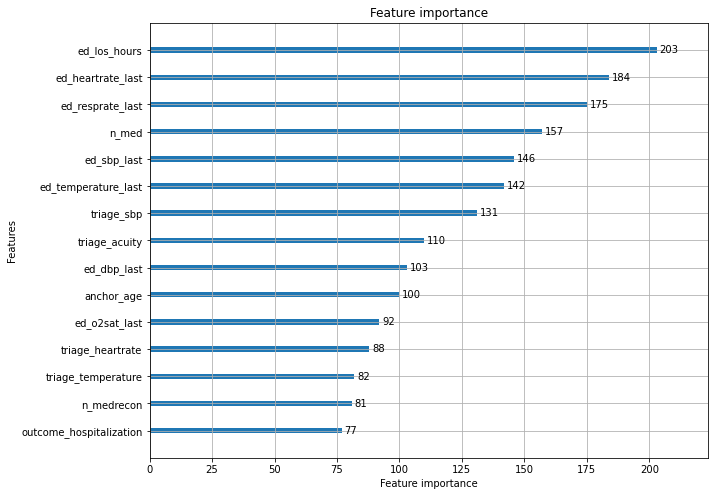

In [27]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model_class, max_num_features=15, ax=ax)

In [21]:
def setting(y_pred):
    for i in range(len(y_pred)):
        if y_pred[i]>=.5:       # setting threshold to .5
           y_pred[i]=1
        else:  
           y_pred[i]=0

In [17]:
# XGB 모델 예측 성능 평가
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f},\nF1: {3: .4f}, AUC: {4: .4f}'.format(accuracy, precision, recall, f1, roc_auc))